This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fai-courses%2Fautonomous_systems_ml/HEAD?filepath=notebooks%2F3_model_assesment)

In [5]:
%matplotlib inline


# Nested versus non-nested cross-validation

## Proper estimation of the test error

This example compares non-nested and nested cross-validation strategies on a
classifier of the iris data set. Nested cross-validation (CV) is often used to
train a model in which hyperparameters also need to be optimized. Nested CV
estimates the generalization error of the underlying model and its
(hyper)parameter search. Choosing the parameters that maximize non-nested CV
biases the model to the dataset, yielding an overly-optimistic score.

Model selection without nested CV uses the same data to tune model parameters
and evaluate model performance. Information may thus "leak" into the model
and overfit the data. The magnitude of this effect is primarily dependent on
the size of the dataset and the stability of the model. See Cawley and Talbot
[1] for an analysis of these issues.

To avoid this problem, nested CV effectively uses a series of
train/validation/test set splits. In the inner loop (here executed by
:class:`GridSearchCV <sklearn.model_selection.GridSearchCV>`), the score is
approximately maximized by fitting a model to each training set, and then
directly maximized in selecting (hyper)parameters over the validation set. In
the outer loop (here in :func:`cross_val_score
<sklearn.model_selection.cross_val_score>`), generalization error is estimated
by averaging test set scores over several dataset splits.

The example below uses a [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
with optimized hyperparameters by grid search. We compare the
performance of non-nested and nested CV strategies by taking the difference
between their scores.


     [1] `Cawley, G.C.; Talbot, N.L.C. On over-fitting in model selection and
     subsequent selection bias in performance evaluation.
     J. Mach. Learn. Res 2010,11, 2079-2107.
     <http://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf>`_


In [27]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
import numpy as np

print(__doc__)

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=0, stratify=iris.target)

# Set up possible values of parameters to optimize over
p_grid = {"n_neighbors": [1,4,7,10],
          "metric": ["euclidean", "manhattan", "chebyshev"]}


# We will use a nearest neighbors classifier
knn = KNeighborsClassifier() # Creation of the classifier

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)
results = dict(best_estimator_entire=list(), best_estimator=list(), accuracy_entire=list(), accuracy=list())

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    
    # Non_nested hyperparameter search and scoring
    clf_entire = GridSearchCV(estimator=knn, param_grid=p_grid, cv=inner_cv, n_jobs)
    clf = GridSearchCV(estimator=knn, param_grid=p_grid, cv=inner_cv, n_jobs)
    clf_entire.fit(X_iris, y_iris)
    clf.fit(X_train, y_train)
    results['best_estimator_entire'].append(clf_entire.best_estimator_)
    results['best_estimator'].append(clf.best_estimator_)
    
    # Nested CV with parameter optimization to get a more accurate estimation 
    # of the test error with the hyperparameters selected in the previous (inner) CV.
    results['accuracy_entire'].append(cross_val_score(clf_entire, X=X_iris, y=y_iris, cv=outer_cv).mean())
    results['accuracy'].append(cross_val_score(clf, X=X_test, y=y_test, cv=outer_cv).mean())
    
    print(f'Best estimator: {results["best_estimator"][-1]} - \
            Accuracy: {results["accuracy"][-1]}')
    print(f'Best estimator entire: {results["best_estimator_entire"][-1]} - \
            Accuracy entire: {results["accuracy_entire"][-1]}')


Automatically created module for IPython interactive environment
Best estimator: KNeighborsClassifier(metric='chebyshev', n_neighbors=7) -             Accuracy: 0.9545454545454546
Best estimator entire: KNeighborsClassifier(metric='chebyshev', n_neighbors=7) -             Accuracy entire: 0.9470128022759602
Best estimator: KNeighborsClassifier(metric='chebyshev', n_neighbors=1) -             Accuracy: 1.0
Best estimator entire: KNeighborsClassifier(metric='chebyshev', n_neighbors=7) -             Accuracy entire: 0.9265647226173541
Best estimator: KNeighborsClassifier(metric='chebyshev', n_neighbors=1) -             Accuracy: 0.9564393939393939
Best estimator entire: KNeighborsClassifier(metric='euclidean', n_neighbors=7) -             Accuracy entire: 0.9598150782361309
Best estimator: KNeighborsClassifier(metric='euclidean', n_neighbors=7) -             Accuracy: 0.9791666666666666
Best estimator entire: KNeighborsClassifier(metric='euclidean', n_neighbors=10) -             Accuracy 

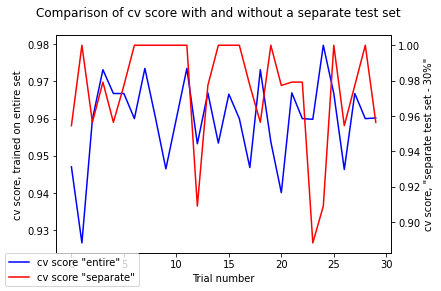

<Figure size 1440x720 with 0 Axes>

In [28]:
# Plot scores on each trial for nested and non-nested CV
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

plt.figure(figsize=(20,10))
ax1.plot(range(NUM_TRIALS), results['accuracy_entire'], '-b')
ax1.set_xlabel('Trial number')
ax1.set_ylabel('cv score, trained on entire set')

ax2.plot(range(NUM_TRIALS), results['accuracy'], '-r')
ax2.set_ylabel('cv score, "separate test set - 30%"')

fig.legend(['cv score "entire"', 'cv score "separate"'], loc='lower left')
fig.suptitle('Comparison of cv score with and without a separate test set')

plt.show()

## Exercise:
  1. Explain why the prediction performances estimated by non-nested CV 
    is optimistic with respect to the nested CV ones.
  2. Which estimator do you think most reliable for the test error?

A current alternative in machine learning is to split the original dataset to get a **separate test set**.
A standard (i.e. non nested) cross-validation procedure can then be applied on the remaining data set. The samples in the test set are now only used to evaluate the test error.
This is different to nested cross-validation where the test samples used in the outer-loop are also used in the inner-loop to train or validate the model.

  3. Why use a separate test set in addition to the validation set?
  4. What are the benefits (or disavantages) of nested cross-validation w.r.t. the "separate test set" split approach?
  5. **Optional:** Implement the "separate test set" approach on this example and compare with the nested cross-validation (*hint:* you may use `train_test_split()`, `GridSearchCV()`, `cross_val_score()` sklearn functions). Compare and interpret your results.
  